94765736/94765736 [==============================] - 5s 0us/step
Found 12599 images belonging to 16 classes.
Found 3141 images belonging to 16 classes.
Found 15740 images belonging to 16 classes.
Epoch 1/10
393/393 [==============================] - 179s 342ms/step - loss: 1.4709 - accuracy: 0.8564 - val_loss: 3.9606 - val_accuracy: 0.1126
Epoch 2/10
393/393 [==============================] - 82s 209ms/step - loss: 0.9318 - accuracy: 0.9582 - val_loss: 1.4234 - val_accuracy: 0.8029
Epoch 3/10
393/393 [==============================] - 82s 209ms/step - loss: 0.7501 - accuracy: 0.9690 - val_loss: 0.9466 - val_accuracy: 0.9040
Epoch 4/10
393/393 [==============================] - 82s 209ms/step - loss: 0.6195 - accuracy: 0.9795 - val_loss: 0.7769 - val_accuracy: 0.9321
Epoch 5/10
393/393 [==============================] - 82s 210ms/step - loss: 0.5245 - accuracy: 0.9825 - val_loss: 0.7371 - val_accuracy: 0.9228
Epoch 6/10
393/393 [==============================] - 83s 210ms/step - loss: 0

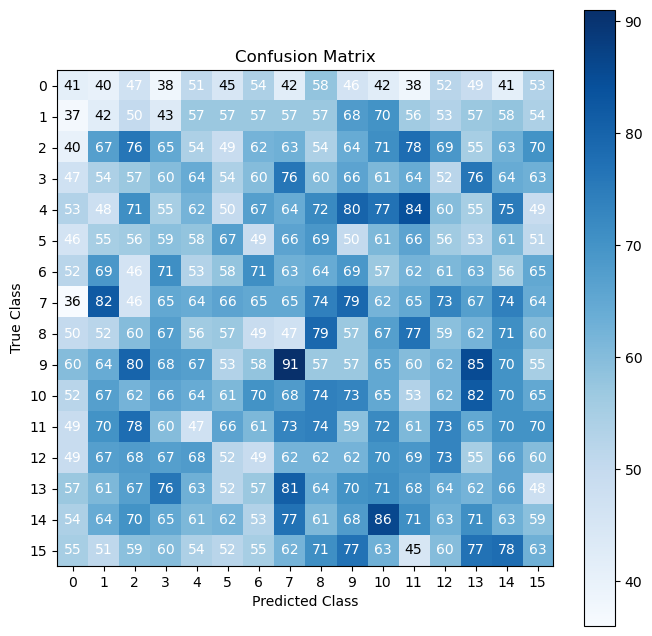

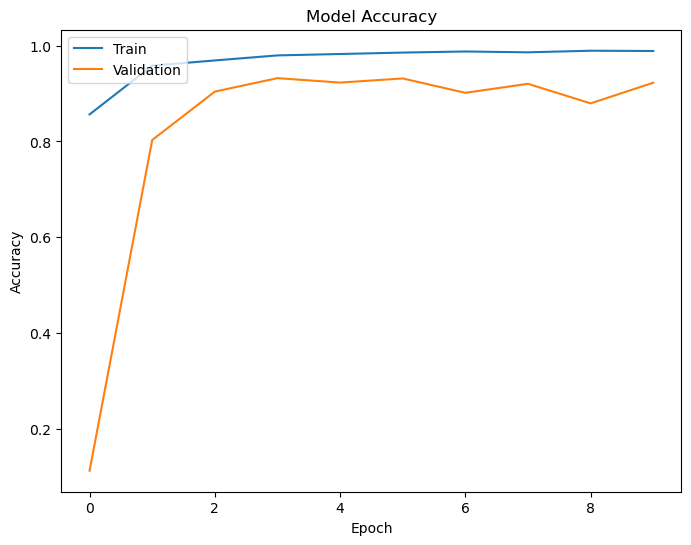

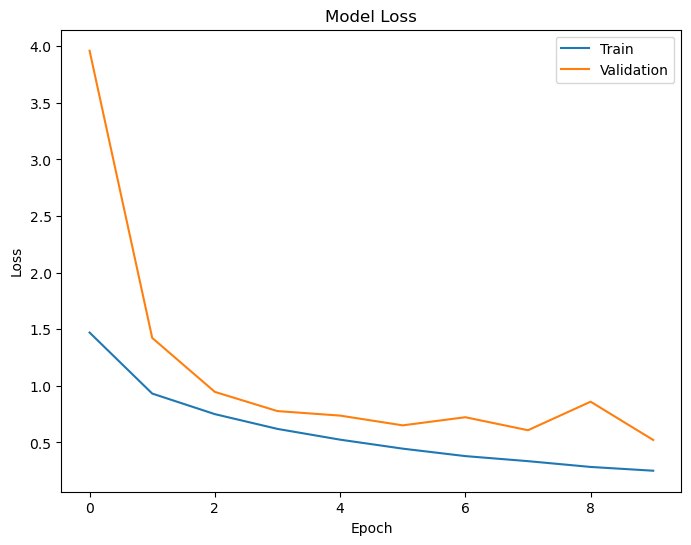

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
NUM_CLASSES = 16  
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10

# pre-trained on ImageNet
base_model = ResNet50(
    weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
)

# Add custom layers
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# ResNet50 model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = True

# Compile model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess data
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/flowers/flowers/',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/flowers/flowers/',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/flowers/flowers/',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS
)

# Evaluate the model 
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the model on the test set
predictions = model.predict(test_generator)
y_true = test_generator.classes[:predictions.shape[0]]  # Adjust the length of y_true
y_pred = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, range(NUM_CLASSES))
plt.yticks(tick_marks, range(NUM_CLASSES))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Add labels to each cell
thresh = cm.max() / 2.0
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
